# 160. 사전 훈련 모델(pre-trained model)을 이용한 Transfer Learning 

- Keras 에 내장된 ResNet50 pre-trained model 사용

- 1000 개의 class 를 분류하는 모델인 ResNet50 을 binary classifier (cat, dog) 로 변형

- My Drive 에 training data upload

# STEP #1: IMPORT LIBRARIES

In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# STEP #2: PRE-TRAINED WEIGHT 를 가진 모델 import

In [2]:
model = tf.keras.applications.ResNet50(weights = 'imagenet')

102973440/102967424 [==============================] - 4s 0us/step


# STEP #3: PRE-TRAINED MODEL 평가

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**tf.keras.preprocessing.image.load_img** - image 를 PIL (Python Image Library) format 으로 load

In [0]:
sample_image= tf.keras.preprocessing.image.load_img(r'/content/drive/My Drive//TransferLearningData/train/cats/cat.1.jpg', target_size = (224, 224))

In [16]:
type(sample_image)

PIL.Image.Image

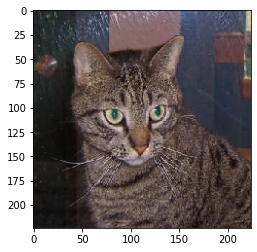

In [17]:
plt.imshow(sample_image)

**tf.keras.preprocessing.image.img_to_array** - PIL image 를 numpy array 로 변경

In [0]:
sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)

In [19]:
np.shape(sample_image)

(224, 224, 3)

In [20]:
sample_image = np.expand_dims(sample_image, axis = 0)
np.shape(sample_image)

(1, 224, 224, 3)

### resnet50.preprocess_input method 를 이용하여 ResNet50 의 입력 spec 에 맞도록  sample_image 를 전처리

In [0]:
sample_image = tf.keras.applications.resnet50.preprocess_input(sample_image)

In [23]:
predictions = model.predict(sample_image)
print(predictions.shape)
print(predictions[0,:20])        # 1000 가지 class 에 대한 확률 분포

(1, 1000)
[2.7419269e-06 5.6985627e-06 1.0418095e-06 3.2217984e-06 1.4534779e-06
 2.9874411e-06 3.1724736e-07 6.9296070e-06 2.2804720e-06 3.7903513e-07
 2.2786526e-06 8.6919266e-07 3.8654741e-07 1.9398028e-07 3.6135998e-07
 1.3332281e-06 1.4278757e-07 1.0025960e-06 1.5506447e-06 8.6567645e-08]


### 확률 분포로 반환된 prediction 을 category name 으로 decode

- resnet50.decode_predictions method 를 이용하여 top 5 확률의 class 를 class 명과 함께 반환  
-  `(class_name, class_description, score)`

In [24]:
print('predictions:', tf.keras.applications.resnet50.decode_predictions(predictions, top = 5)[0])

40960/35363 [==================================] - 0s 0us/step
predictions: [('n02123045', 'tabby', 0.29471582), ('n02124075', 'Egyptian_cat', 0.25365275), ('n02123159', 'tiger_cat', 0.2168709), ('n02971356', 'carton', 0.026583176), ('n03958227', 'plastic_bag', 0.023729654)]


### ImageDataGenerator 를 이용하여 train data 생성

In [25]:
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function= tf.keras.applications.resnet50.preprocess_input)

train_generator = image_datagen.flow_from_directory('/content/drive/My Drive/TransferLearningData/train/', 
                                                   target_size = (224, 224),
                                                   color_mode = 'rgb',
                                                   batch_size = 32,
                                                   class_mode = 'categorical',
                                                   shuffle = True)

Found 202 images belonging to 2 classes.


# STEP #4: TRANSFER LEARNING (전이학습) 적용 및 model Fine-Tuning 

- ResNet50 의 top layer 제거 (include_top = False)  

- Top layer 를 제거한 위치에 GlobalAaveragePooling2D 와 5 개의  Dense layer 추가
    - global_average_layer = keras.layers.GlobalAveragePooling2D()(base_model.output)
    - prediction_layer = keras.layers.Dense(units=2, activation='softmax')(global_average_layer)

In [26]:
base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False)
full_model    = tf.keras.applications.ResNet50(weights= 'imagenet', include_top = True)

94773248/94765736 [==============================] - 4s 0us/step


In [27]:
print(full_model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

- top layer 가 truncate 된 base_model 과 full_model 비교

In [28]:
for layer in base_model.layers[-5:]:
    print(layer.name)
print()
for layer in full_model.layers[-7:]:
    print(layer.name)

conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out

conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
avg_pool
predictions


### base model 의 마지막에 5 개 layer 추가

In [0]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
preds = tf.keras.layers.Dense(2, activation = 'softmax')(x)

In [0]:
model = tf.keras.models.Model(inputs = base_model.input, outputs = preds)

In [50]:
for layer in model.layers[-10:]:
    print(layer.name)

conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
global_average_pooling2d_1
dense_5
dense_6
dense_7
dense_8
dense_9


### Fine tuning 하기 전에 새로이 add 한 layer 들을 1 차 training 하여 초기화

In [0]:
for layer in model.layers[:-5]:       
    layer.trainable = False              # weight freeze

for layer in model.layers[-5:]:       # last 5 layer 
    layer.trainable = True

In [0]:
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [53]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [54]:
%%time
model.fit_generator(generator = train_generator,  epochs = 5)

Epoch 1/5
7/7 [==============================] - 1s 124ms/step - loss: 0.7509 - accuracy: 0.8366
Epoch 2/5
7/7 [==============================] - 1s 126ms/step - loss: 0.1964 - accuracy: 0.9752
Epoch 3/5
7/7 [==============================] - 1s 124ms/step - loss: 0.1311 - accuracy: 0.9752
Epoch 4/5
7/7 [==============================] - 1s 127ms/step - loss: 0.7556 - accuracy: 0.9653
Epoch 5/5
7/7 [==============================] - 1s 122ms/step - loss: 10.1304 - accuracy: 0.9257
CPU times: user 7.13 s, sys: 381 ms, total: 7.51 s
Wall time: 8.15 s


### 마지막 50 개 layer 만 fine tuning

In [0]:
for layer in model.layers[:-50]:
    layer.trainable = False

In [0]:
for layer in model.layers[-50:]:
    layer.trainable = True

In [0]:
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

- steps_per_epoch : Total number of steps (batches of samples) to yield from generator

In [58]:
history = model.fit_generator(generator = train_generator, epochs = 10)

Epoch 1/10
7/7 [==============================] - 1s 138ms/step - loss: 0.0232 - accuracy: 0.9950
Epoch 2/10
7/7 [==============================] - 1s 143ms/step - loss: 0.1543 - accuracy: 0.9851
Epoch 3/10
7/7 [==============================] - 1s 135ms/step - loss: 0.0405 - accuracy: 0.9950
Epoch 4/10
7/7 [==============================] - 1s 133ms/step - loss: 1.0921 - accuracy: 0.9554
Epoch 5/10
7/7 [==============================] - 1s 143ms/step - loss: 0.0281 - accuracy: 0.9901
Epoch 6/10
7/7 [==============================] - 1s 142ms/step - loss: 0.0298 - accuracy: 0.9901
Epoch 7/10
7/7 [==============================] - 1s 145ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 8/10
7/7 [==============================] - 1s 142ms/step - loss: 3.1861e-05 - accuracy: 1.0000
Epoch 9/10
7/7 [==============================] - 1s 142ms/step - loss: 2.0301e-04 - accuracy: 1.0000
Epoch 10/10
7/7 [==============================] - 1s 143ms/step - loss: 1.5813e-05 - accuracy: 1.0000


# STEP #5: EVALUATE THE MODEL

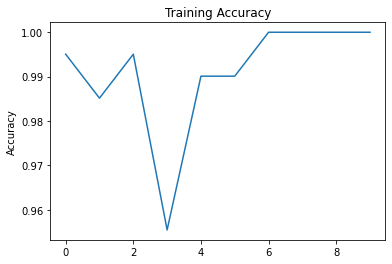

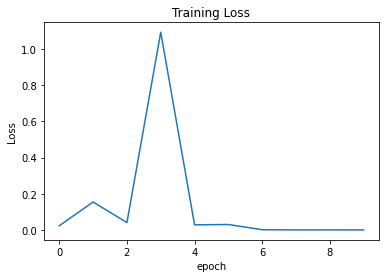

In [59]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure()
plt.plot(acc, label='Training Accuracy')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.figure()

plt.plot(loss, label='Training Loss')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [63]:
predictions = model.predict(sample_image)
print(predictions.shape)
print('Predictions:', predictions)

(1, 2)
Predictions: [[1. 0.]]
